In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.1-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.1-bin-hadoop3.tgz
!pip install findspark
!pip install pyspark

--2023-02-19 14:35:58--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-19 14:35:58 ERROR 404: Not Found.


gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 13.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=2b990add095f3e0ede5dbc34571876c12570f8e4

In [2]:
import numpy as np
import json
import glob
import os
import time
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

import seaborn as sns
import copy

import warnings
warnings.simplefilter(action='ignore')

In [3]:
import findspark
import random
import pyspark
from pyspark.sql import functions as f
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression

In [4]:
# initiaiting spark context
findspark.init()
sc = pyspark.SparkContext("local", appName="MillionSongsPredictions")

In [7]:
# open data directly from file
spark = SparkSession(sc)
full_data = spark.read.option("escape","\"").csv("/content/drive/MyDrive/bdp/final project/cleaned_data.csv", header=True, sep=',', multiLine=True)

In [8]:
full_data = full_data.withColumn('hit', when(full_data['song_hotttnesss'] >=0.5,1).otherwise(0))

In [9]:
full_data.show(5)

+--------------------+--------------------+--------------------+--------------------+---------------+----------------+------------------+---------------+--------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+--------------+------------+---+
|                 _c0|  artist_familiarity|   artist_hotttnesss|           artist_id|artist_latitude|artist_l

# Splitting in training and test set

In [10]:
training_columns = ['artist_familiarity', 'artist_idIndex', 'artist_hotttnesss', 'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness', 'mode', 'start_of_fade_out', 'tempo', 'time_signature', 'time_signature_confidence', 'year']

In [11]:
full_data = full_data.withColumn("duration",f.col("duration").cast("float"))
full_data = full_data.withColumn("end_of_fade_in",f.col("end_of_fade_in").cast("float"))
full_data = full_data.withColumn("key",f.col("key").cast("int"))
full_data = full_data.withColumn("key_confidence",f.col("key_confidence").cast("float"))
full_data = full_data.withColumn("loudness",f.col("loudness").cast("float"))
full_data = full_data.withColumn("mode",f.col("mode").cast("float"))
full_data = full_data.withColumn("start_of_fade_out",f.col("start_of_fade_out").cast("float"))
full_data = full_data.withColumn("tempo",f.col("tempo").cast("float"))
full_data = full_data.withColumn("artist_hotttnesss",f.col("artist_hotttnesss").cast("float"))
full_data = full_data.withColumn("time_signature",f.col("time_signature").cast("float"))
full_data = full_data.withColumn("time_signature_confidence",f.col("time_signature_confidence").cast("float"))
full_data = full_data.withColumn("year",f.col("year").cast("float"))
full_data = full_data.withColumn("artist_idIndex",f.col("artist_idIndex").cast("float"))
full_data = full_data.withColumn("artist_familiarity",f.col("artist_familiarity").cast("float"))

In [12]:
dat_assembler = VectorAssembler(inputCols=training_columns, outputCol='features', handleInvalid="keep")

In [13]:
ready_data = dat_assembler.transform(full_data).select('features','hit')

In [14]:
train_data, val_data = ready_data.randomSplit([0.67, 0.33])

# Using a **Random Forests** to make predictions

In [15]:
rfc = RandomForestClassifier(labelCol='hit', featuresCol='features',numTrees=20,maxDepth=5)
rfc_model = rfc.fit(train_data)


In [16]:
rfc_preds = rfc_model.transform(val_data)

In [17]:
rfc_preds.show(5)

+--------------------+---+--------------------+--------------------+----------+
|            features|hit|       rawPrediction|         probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
|[0.0,1287.0,0.0,1...|  0|[18.8623656441215...|[0.94311828220607...|       0.0|
|[0.0,1287.0,0.0,2...|  0|[18.9945531254721...|[0.94972765627360...|       0.0|
|[0.0,2584.0,0.296...|  1|[19.1948221931271...|[0.95974110965635...|       0.0|
|[0.0,2949.0,0.370...|  1|[18.3320227681764...|[0.91660113840882...|       0.0|
|[0.0,3056.0,0.251...|  0|[18.9347791081540...|[0.94673895540770...|       0.0|
+--------------------+---+--------------------+--------------------+----------+
only showing top 5 rows



In [18]:
auc = BinaryClassificationEvaluator(labelCol='hit')

In [19]:
print('AUC:', auc.evaluate(rfc_preds))

AUC: 0.7809810874544925


In [20]:
evaluator = MulticlassClassificationEvaluator(labelCol="hit", predictionCol="prediction",metricName="accuracy")

In [21]:
print('Accuracy:', evaluator.evaluate(rfc_preds))

Accuracy: 0.8456131846825012


# Using a **Logistic Regression** to make predictions

In [22]:
lr = LogisticRegression(labelCol="hit", featuresCol="features",regParam=0.1, elasticNetParam=1.0, family="multinomial")
lr_model = lr.fit(train_data)

In [23]:
lr_preds = lr_model.transform(val_data)

In [24]:
print('AUC:', auc.evaluate(lr_preds))

AUC: 0.5


In [25]:
print('Accuracy:', evaluator.evaluate(lr_preds))

Accuracy: 0.8456131846825012


# Using a **Decision Tree** to make predictions

In [26]:
dt = DecisionTreeClassifier(labelCol="hit", featuresCol="features", maxDepth=20,maxBins=50)

In [27]:
dt_model = dt.fit(train_data)
dt_preds = dt_model.transform(val_data)

In [28]:
print('AUC:', auc.evaluate(dt_preds))

AUC: 0.5472275953175106


In [29]:
print('Accuracy:', evaluator.evaluate(dt_preds))

Accuracy: 0.8024721279689773


# EVALUATION

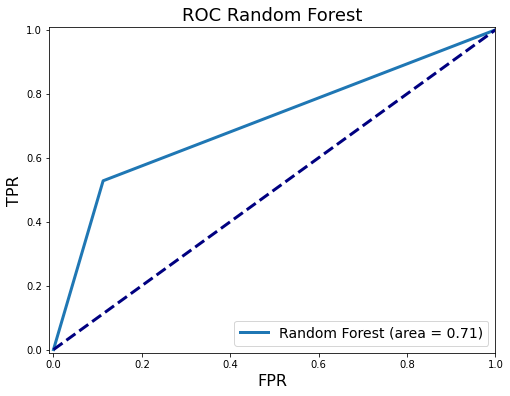

In [ ]:
# Calculate AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Random Forest', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Random Forest (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=14)
plt.show()

In [ ]:
# # Calculate AUC
# from sklearn.metrics import roc_curve, auc
# fpr, tpr, _ = roc_curve(y_test, y_pred_xgb)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.title('ROC XGB', fontsize=18)
# plt.xlabel('FPR', fontsize=16)
# plt.ylabel('TPR', fontsize=16)
# plt.xlim([-0.01, 1.00])
# plt.ylim([-0.01, 1.01])
# plt.plot(fpr, tpr, lw=3, label='XGB (area = {:0.2f})'.format(roc_auc))
# plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
# plt.legend(loc='lower right', fontsize=14)
# plt.show()

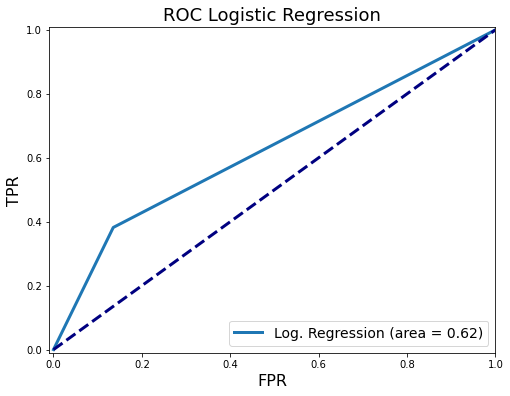

In [ ]:
# Calculate AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_logreg)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Logistic Regression', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Log. Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=14)
plt.show()

In [ ]:
# # Calculate AUC
# from sklearn.metrics import roc_curve, auc
# fpr, tpr, _ = roc_curve(y_test, y_pred_knn)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.title('KNN', fontsize=18)
# plt.xlabel('FPR', fontsize=16)
# plt.ylabel('TPR', fontsize=16)
# plt.xlim([-0.01, 1.00])
# plt.ylim([-0.01, 1.01])
# plt.plot(fpr, tpr, lw=3, label='KNN (area = {:0.2f})'.format(roc_auc))
# plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
# plt.legend(loc='lower right', fontsize=14)
# plt.show()

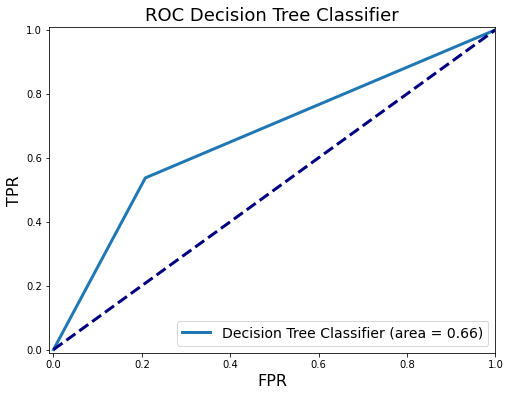

In [ ]:
# Calculate AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_dtc)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Decision Tree Classifier', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Decision Tree Classifier (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=14)
plt.show()

In [ ]:
result = pd.DataFrame({
            'Random Forest':[acc_rf, TPR_rf, FPR_rf],
#             'XGB':[acc_xgb, TPR_xgb, FPR_xgb],
            'Logistic Regression':[acc_logreg, TPR_logreg, FPR_logreg],
#             'KNN':[acc_knn, TPR_knn, FPR_knn],
            'Decision Tree Classifier':[acc_dtc, TPR_dtc, FPR_dtc],
            },
            index=['Accuracy','TPR','FPR']).transpose()

result = result.sort_values(['Accuracy', 'TPR', 'FPR'], 
                    ascending = [False, False, True])

result

,Accuracy,TPR,FPR
Random Forest,0.780579,0.527928,0.112299
Logistic Regression,0.721030,0.381982,0.135218
Decision Tree Classifier,0.716202,0.536937,0.207792
